## Step 1: Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Step 2: Global Configuration

In [2]:
DATA_ROOT = r"E:\InstruNet-AI\data\post_preprocessing\irmas_mono"

INPUT_SHAPE = (128, 126, 1)
NUM_CLASSES = 11
WINDOW_SEC = 3.0
HOP_SEC = 1.5
SR = 16000

BATCH_SIZE = 128
EPOCHS = 50

## Step 3: Load Label Map

In [3]:
import json

with open(r"E:\InstruNet-AI\data\splits\label_map.json", "r") as f:
    class_to_id = json.load(f)

id_to_class = {v: k for k, v in class_to_id.items()}

## Step 4: Data Loader (Multi-Label Ready)

In [4]:
def load_split(split):
    X, y = [], []

    split_dir = os.path.join(DATA_ROOT, split)

    for cls in os.listdir(split_dir):
        cls_id = class_to_id[cls]
        cls_dir = os.path.join(split_dir, cls)

        for file in os.listdir(cls_dir):
            if file.endswith(".npy"):
                mel = np.load(os.path.join(cls_dir, file))
                mel = mel[..., np.newaxis]

                label = np.zeros(NUM_CLASSES)
                label[cls_id] = 1  # multi-label compatible

                X.append(mel)
                y.append(label)

    return np.array(X), np.array(y)

## Step 5: Load Train / Val / Test

In [5]:
X_train, y_train = load_split("train")
X_val, y_val     = load_split("val")
X_test, y_test   = load_split("test")

print(X_train.shape, y_train.shape)

(4692, 128, 126, 1) (4692, 11)


## Step 6: CNN Architecture (For baseline model to avoid regularization)

In [6]:
def build_instrunet_baseline():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (5,5), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (5,5), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (5,5), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (5,5), padding="same", activation="relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

## Step 7: Compile Model (BCE + SGD)

In [7]:
model = build_instrunet_baseline()

optimizer = optimizers.Adam(
    learning_rate=0.001,   # Adam requires lower LR than SGD
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")
    ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 126, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 63, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 31, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 15, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,079,307 (4.12 MB)

 Trainable params: 1,079,307 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

## Step 8: Callbacks

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_baseline_model_2.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

## Step 9: Class Weights Preparation

In [9]:
# Inverse frequency weighting
class_counts = y_train.sum(axis=0)
total_samples = y_train.shape[0]
num_classes = y_train.shape[1]

class_weights = {
    i: total_samples / (num_classes * class_counts[i])
    for i in range(num_classes)
}

## Step 10: Train Model

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights if class_weights else None,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.8653 - loss: 0.3753

37/37 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - binary_accuracy: 0.8986 - loss: 0.3296 - val_binary_accuracy: 0.9091 - val_loss: 0.3081 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3064

37/37 ━━━━━━━━━━━━━━━━━━━━ 191s 5s/step - binary_accuracy: 0.9091 - loss: 0.3054 - val_binary_accuracy: 0.9091 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9091 - loss: 0.3015

37/37 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - binary_accuracy: 0.9091 - loss: 0.3007 - val_binary_accuracy: 0.9092 - val_loss: 0.2985 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9092 - loss: 0.2923

37/37 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - binary_accuracy: 0.9093 - loss: 0.2888 - val_binary_accuracy: 0.9092 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9093 - loss: 0.2805

37/37 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - binary_accuracy: 0.9093 - loss: 0.2787 - val_binary_accuracy: 0.9102 - val_loss: 0.2716 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9096 - loss: 0.2702

37/37 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - binary_accuracy: 0.9101 - loss: 0.2664 - val_binary_accuracy: 0.9114 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - binary_accuracy: 0.9103 - loss: 0.2617

37/37 ━━━━━━━━━━━━━━━━━━━━ 294s 8s/step - binary_accuracy: 0.9106 - loss: 0.2583 - val_binary_accuracy: 0.9111 - val_loss: 0.2546 - learning_rate: 0.0010
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9117 - loss: 0.2498

37/37 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - binary_accuracy: 0.9116 - loss: 0.2501 - val_binary_accuracy: 0.9134 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9129 - loss: 0.2475

37/37 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - binary_accuracy: 0.9133 - loss: 0.2440 - val_binary_accuracy: 0.9132 - val_loss: 0.2418 - learning_rate: 0.0010
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9154 - loss: 0.2346

37/37 ━━━━━━━━━━━━━━━━━━━━ 187s 5s/step - binary_accuracy: 0.9163 - loss: 0.2329 - val_binary_accuracy: 0.9139 - val_loss: 0.2388 - learning_rate: 0.0010
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9185 - loss: 0.2277

37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - binary_accuracy: 0.9188 - loss: 0.2264 - val_binary_accuracy: 0.9142 - val_loss: 0.2348 - learning_rate: 0.0010
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - binary_accuracy: 0.9205 - loss: 0.2220

37/37 ━━━━━━━━━━━━━━━━━━━━ 303s 8s/step - binary_accuracy: 0.9213 - loss: 0.2187 - val_binary_accuracy: 0.9181 - val_loss: 0.2199 - learning_rate: 0.0010
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9221 - loss: 0.2176

37/37 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - binary_accuracy: 0.9221 - loss: 0.2153 - val_binary_accuracy: 0.9221 - val_loss: 0.2174 - learning_rate: 0.0010
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9222 - loss: 0.2116

37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - binary_accuracy: 0.9237 - loss: 0.2096 - val_binary_accuracy: 0.9207 - val_loss: 0.2118 - learning_rate: 0.0010
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9273 - loss: 0.2001

37/37 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - binary_accuracy: 0.9273 - loss: 0.2003 - val_binary_accuracy: 0.9260 - val_loss: 0.2058 - learning_rate: 0.0010
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9304 - loss: 0.1945

37/37 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - binary_accuracy: 0.9297 - loss: 0.1959 - val_binary_accuracy: 0.9281 - val_loss: 0.1992 - learning_rate: 0.0010
Epoch 17/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - binary_accuracy: 0.9317 - loss: 0.1875 - val_binary_accuracy: 0.9264 - val_loss: 0.1994 - learning_rate: 0.0010
Epoch 18/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9330 - loss: 0.1862

37/37 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - binary_accuracy: 0.9329 - loss: 0.1843 - val_binary_accuracy: 0.9290 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 19/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9350 - loss: 0.1769

37/37 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - binary_accuracy: 0.9361 - loss: 0.1757 - val_binary_accuracy: 0.9305 - val_loss: 0.1915 - learning_rate: 0.0010
Epoch 20/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9376 - loss: 0.1713

37/37 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - binary_accuracy: 0.9376 - loss: 0.1703 - val_binary_accuracy: 0.9329 - val_loss: 0.1875 - learning_rate: 0.0010
Epoch 21/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9390 - loss: 0.1697

37/37 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - binary_accuracy: 0.9385 - loss: 0.1706 - val_binary_accuracy: 0.9331 - val_loss: 0.1853 - learning_rate: 0.0010
Epoch 22/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9391 - loss: 0.1661

37/37 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - binary_accuracy: 0.9394 - loss: 0.1648 - val_binary_accuracy: 0.9344 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 23/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9404 - loss: 0.1599

37/37 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - binary_accuracy: 0.9395 - loss: 0.1642 - val_binary_accuracy: 0.9330 - val_loss: 0.1799 - learning_rate: 0.0010
Epoch 24/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - binary_accuracy: 0.9432 - loss: 0.1556 - val_binary_accuracy: 0.9353 - val_loss: 0.1827 - learning_rate: 0.0010
Epoch 25/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9452 - loss: 0.1515

37/37 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - binary_accuracy: 0.9456 - loss: 0.1506 - val_binary_accuracy: 0.9358 - val_loss: 0.1776 - learning_rate: 0.0010
Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9468 - loss: 0.1457

37/37 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - binary_accuracy: 0.9466 - loss: 0.1459 - val_binary_accuracy: 0.9350 - val_loss: 0.1748 - learning_rate: 0.0010
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9483 - loss: 0.1400

37/37 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - binary_accuracy: 0.9492 - loss: 0.1383 - val_binary_accuracy: 0.9416 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 233s 5s/step - binary_accuracy: 0.9507 - loss: 0.1398 - val_binary_accuracy: 0.9374 - val_loss: 0.1761 - learning_rate: 0.0010
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - binary_accuracy: 0.9523 - loss: 0.1317 - val_binary_accuracy: 0.9390 - val_loss: 0.1679 - learning_rate: 0.0010
Epoch 30/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - binary_accuracy: 0.9545 - loss: 0.1234 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1609s 44s/step - binary_accuracy: 0.9540 - loss: 0.1255 - val_binary_accuracy: 0.9425 - val_loss: 0.1609 - learning_rate: 0.0010
Epoch 31/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - binary_accuracy: 0.9548 - loss: 0.1239 - val_binary_accuracy: 0.9392 - val_loss: 0.1660 - learning_rate: 0.0010
Epoch 32/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9529 - loss: 0.1256

37/37 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - binary_accuracy: 0.9548 - loss: 0.1225 - val_binary_accuracy: 0.9436 - val_loss: 0.1602 - learning_rate: 0.0010
Epoch 33/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - binary_accuracy: 0.9580 - loss: 0.1154 - val_binary_accuracy: 0.9418 - val_loss: 0.1621 - learning_rate: 0.0010
Epoch 34/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - binary_accuracy: 0.9593 - loss: 0.1119 - val_binary_accuracy: 0.9424 - val_loss: 0.1740 - learning_rate: 0.0010
Epoch 35/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9608 - loss: 0.1074

37/37 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - binary_accuracy: 0.9613 - loss: 0.1069 - val_binary_accuracy: 0.9456 - val_loss: 0.1582 - learning_rate: 0.0010
Epoch 36/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - binary_accuracy: 0.9609 - loss: 0.1055 - val_binary_accuracy: 0.9420 - val_loss: 0.1653 - learning_rate: 0.0010
Epoch 37/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9621 - loss: 0.1029

37/37 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - binary_accuracy: 0.9607 - loss: 0.1040 - val_binary_accuracy: 0.9453 - val_loss: 0.1579 - learning_rate: 0.0010
Epoch 38/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - binary_accuracy: 0.9661 - loss: 0.0941 - val_binary_accuracy: 0.9397 - val_loss: 0.1784 - learning_rate: 0.0010
Epoch 39/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - binary_accuracy: 0.9687 - loss: 0.0873 - val_binary_accuracy: 0.9447 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 40/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.9697 - loss: 0.0837

37/37 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - binary_accuracy: 0.9698 - loss: 0.0842 - val_binary_accuracy: 0.9438 - val_loss: 0.1566 - learning_rate: 0.0010
Epoch 41/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - binary_accuracy: 0.9715 - loss: 0.0805 - val_binary_accuracy: 0.9447 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 42/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - binary_accuracy: 0.9711 - loss: 0.0780 - val_binary_accuracy: 0.9445 - val_loss: 0.1659 - learning_rate: 0.0010
Epoch 43/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - binary_accuracy: 0.9734 - loss: 0.0730 - val_binary_accuracy: 0.9487 - val_loss: 0.1580 - learning_rate: 0.0010
Epoch 44/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9778 - loss: 0.0638

37/37 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - binary_accuracy: 0.9762 - loss: 0.0665 - val_binary_accuracy: 0.9487 - val_loss: 0.1519 - learning_rate: 0.0010
Epoch 45/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - binary_accuracy: 0.9774 - loss: 0.0625 - val_binary_accuracy: 0.9480 - val_loss: 0.1593 - learning_rate: 0.0010
Epoch 46/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - binary_accuracy: 0.9778 - loss: 0.0598 - val_binary_accuracy: 0.9459 - val_loss: 0.1680 - learning_rate: 0.0010
Epoch 47/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - binary_accuracy: 0.9783 - loss: 0.0590 - val_binary_accuracy: 0.9454 - val_loss: 0.1751 - learning_rate: 0.0010
Epoch 48/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - binary_accuracy: 0.9810 - loss: 0.0526 - val_binary_accuracy: 0.9455 - val_loss: 0.1742 - learning_rate: 0.0010
Epoch 49/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 218s 6s/step - binary_accuracy: 0.9838 - loss: 0.0457 - val_binary_accuracy: 0.9489 - val_loss: 0.1736 - learning_rate: 0.0010
Epoch 50/50
37/3

## Step 11: Accuracy Curve

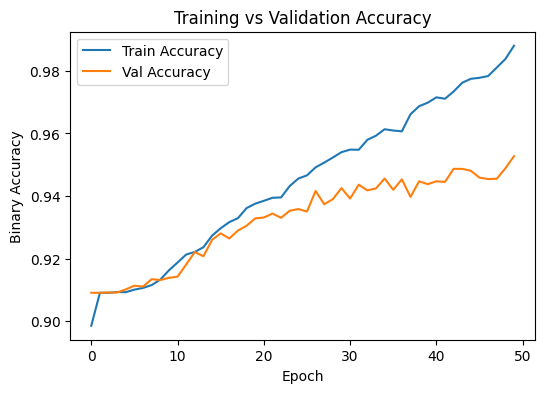

In [11]:
plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.show()

## Step 12: Training Loss and Validation Loss Curves

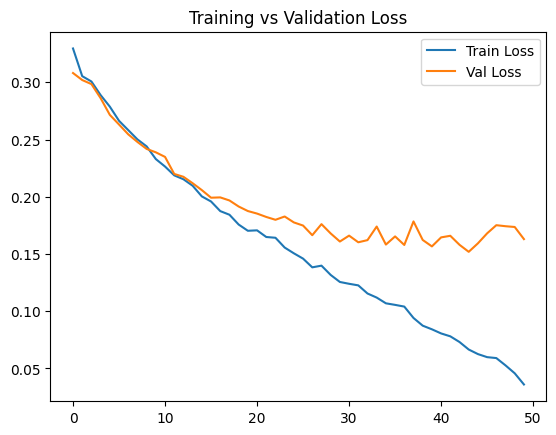

In [12]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Step 13: CNN Architecture (Model with regularization applied)

In [29]:
def build_instrunet_regularized():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (5,5), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

    return models.Model(inputs, outputs)

## Step 14: Model compile (BCE + SGD)

In [30]:
model = build_instrunet_regularized()

optimizer = optimizers.Adam(
    learning_rate=0.001,   # Adam requires lower LR than SGD
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")
    ]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 126, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 63, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 31, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 15, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,227 (4.12 MB)

 Trainable params: 1,080,267 (4.12 MB)

 Non-trainable params: 960 (3.75 KB)

## Step 15: Callbacks

In [31]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='best_baseline_regularized_2.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

In [32]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights if class_weights else None,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.6084 - loss: 0.6668

37/37 ━━━━━━━━━━━━━━━━━━━━ 247s 7s/step - binary_accuracy: 0.6895 - loss: 0.6243 - val_binary_accuracy: 0.7902 - val_loss: 0.5717 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.8762 - loss: 0.4625

37/37 ━━━━━━━━━━━━━━━━━━━━ 261s 6s/step - binary_accuracy: 0.8973 - loss: 0.4046 - val_binary_accuracy: 0.9040 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 261s 6s/step - binary_accuracy: 0.9228 - loss: 0.2478 - val_binary_accuracy: 0.9091 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 264s 7s/step - binary_accuracy: 0.9290 - loss: 0.2040 - val_binary_accuracy: 0.9090 - val_loss: 0.5505 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 269s 7s/step - binary_accuracy: 0.9345 - loss: 0.1824 - val_binary_accuracy: 0.9091 - val_loss: 0.7517 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - binary_accuracy: 0.9404 - loss: 0.1657 - val_binary_accuracy: 0.7668 - val_loss: 0.9094 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 254s 6s/step - binary_accuracy: 0.9464 - loss: 0.1486 - val_binary_accuracy: 0.8150 - val_loss: 0.8190 - learning_rate: 0.0010
Epoch 8/50
37/37 ━━━━

## Step 16: Accuracy Curve

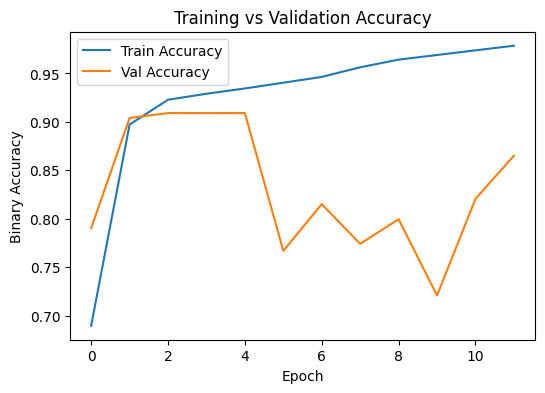

In [33]:
plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.show()

## Step 17:Training Loss and Validation Loss Curves

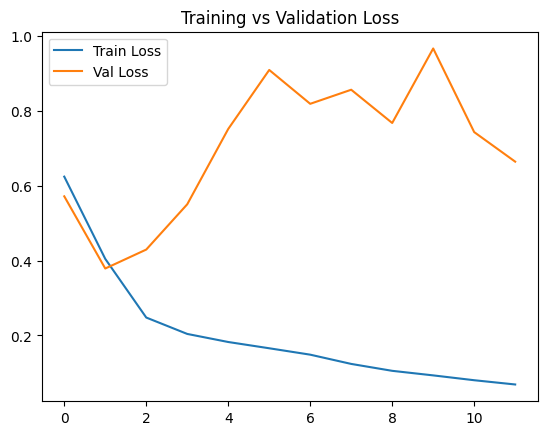

In [34]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Step 19: Model Evaluation with Thresholded Metrics

### (a) Generate probabilities

In [35]:
y_prob = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step


### (b) Apply thresholding

In [36]:
THRESHOLD = 0.3
y_pred = (y_prob >= THRESHOLD).astype(int)

print(f"Using decision threshold = {THRESHOLD}")

Using decision threshold = 0.3


### (c) Global F1 scores

In [37]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score

In [38]:
micro_f1 = f1_score(y_test, y_pred, average="micro")
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("=== Global Metrics ===")
print("Micro F1-score :", round(micro_f1, 4))
print("Macro F1-score :", round(macro_f1, 4))

=== Global Metrics ===
Micro F1-score : 0.1256
Macro F1-score : 0.0583


### (d) Per-class Recall (CRITICAL)

In [39]:
recalls = recall_score(y_test, y_pred, average=None)

print("\n=== Per-class Recall ===")
for i, r in enumerate(recalls):
    print(f"{id_to_class[i]} : {round(r, 3)}")


=== Per-class Recall ===
cel : 1.0
cla : 0.0
flu : 0.0
gac : 1.0
gel : 0.018
org : 0.0
pia : 0.009
sax : 0.0
tru : 0.0
vio : 0.0
voi : 0.333


### (e) Per-class Precision

In [40]:
precisions = precision_score(
    y_test,
    y_pred,
    average=None,
    zero_division=0
)

print("\n=== Per-class Precision ===")
for i, p in enumerate(precisions):
    print(f"{id_to_class[i]} : {round(p, 3)}")


=== Per-class Precision ===
cel : 0.058
cla : 0.0
flu : 0.0
gac : 0.101
gel : 0.5
org : 0.0
pia : 1.0
sax : 0.0
tru : 0.0
vio : 0.0
voi : 0.267


### (f) Per-class Confusion Matrices

In [41]:
print("\n=== Per-class Confusion Matrices ===")
for i in range(NUM_CLASSES):
    print(f"\nConfusion Matrix for {id_to_class[i]}")
    print(confusion_matrix(y_test[:, i], y_pred[:, i]))


=== Per-class Confusion Matrices ===

Confusion Matrix for cel
[[  0 948]
 [  0  58]]

Confusion Matrix for cla
[[930   0]
 [ 76   0]]

Confusion Matrix for flu
[[938   0]
 [ 68   0]]

Confusion Matrix for gac
[[ 63 848]
 [  0  95]]

Confusion Matrix for gel
[[890   2]
 [112   2]]

Confusion Matrix for org
[[903   0]
 [103   0]]

Confusion Matrix for pia
[[898   0]
 [107   1]]

Confusion Matrix for sax
[[912   0]
 [ 94   0]]

Confusion Matrix for tru
[[920   0]
 [ 86   0]]

Confusion Matrix for vio
[[919   0]
 [ 87   0]]

Confusion Matrix for voi
[[782 107]
 [ 78  39]]


### (g) Plotting of ROC-AUC curve (AUC score per class)

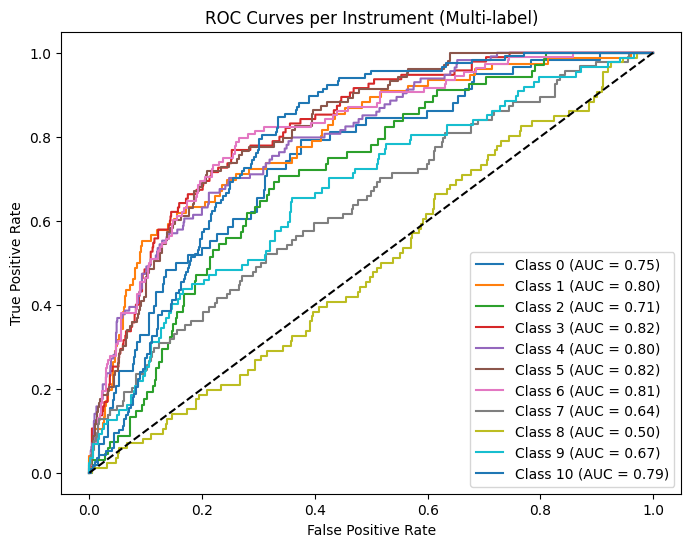

In [42]:
plt.figure(figsize=(8, 6))

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Instrument (Multi-label)")
plt.legend()
plt.show()

### (h) Micro-Averaged and Macro-Averaged F1 Score

In [43]:
micro_auc = roc_auc_score(y_test, y_prob, average="micro")
print("Micro-average ROC–AUC:", micro_auc)

Micro-average ROC–AUC: 0.5444064242773972


In [44]:
macro_auc = roc_auc_score(y_test, y_prob, average="macro")
print("Macro-average ROC–AUC:", macro_auc)

Macro-average ROC–AUC: 0.7365452344023528
